## **EE4211               Question 1**

## Question 1.1
> *Look at the features in the dataset. What does lot type mean?*

**According to the LTA Data mall API user guide, Lot_type means the type of the lots.</br>  Type C is for Cars, type H is for heavy vehicles, and type Y is for motorcycles. The </br> detailed application programming interface is shown below in Table.1**

![Carpark_API](./images/Carpark_API.png)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Table.1  LTA Data mall API [User Guide](https://datamall.lta.gov.sg/content/dam/datamall/datasets/LTA_DataMall_API_User_Guide.pdf)

</br>
</br>
</br>

## Question 1.2 
> *Try making an API call for the data from a single specified date & time. Then, do the same thing for the next second of the initially chosen date & time. Notice that “update time” is unchanged. Carry out and document a systematic approach to approximate the frequency at which the data values are updated. Note: The purpose of this question is to avoid querying for data unnecessarily. Although the API date time parameter is specified to seconds, the database may not be updated every second.*

**We call that api with 1 minute intervals from 10:00 to 22:00 on 15 October 2022, and observed whether the update time of each corresponding parking lot was updated. If there was an update, it was recorded. Finally, we can get the array of update times records of each parking lot, that is a hash table. And we can find the appropriate access frequency based on such an array, by calculating the average gap of the update time records.**


In [ ]:
import requests
import re
import time
import pickle

sleepTime=1
data=dict()

def save_object(obj):
    try:
        with open("data.pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)

def load_object(filename):
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

**We use pickle package to save and load our data in the process.**
**Note: The saved pickle file is not on Google Drive directory. But it’s in the current directory of the Google cloud machine. But we can still access it.**
**The code above extracts the data every minutes and we periodically save the hash table "data" into a pickle file. Note that we use a dictionary variable "data" to server as a hash table which stores the update time records for every parking lot.**

In [ ]:
!pip3 install pickle5
import pickle5 as pickle

In [ ]:
def parse(s):
    hh=int(s[-8:-6])
    mm=int(s[-5:-3])
    ss=int(s[-2:])
    seconds=hh*3600+mm*60+ss
    return seconds

def getGap(arr):
    arr1=[parse(i) for i in arr]
    if(len(arr1)==1):
        return 0
    cnt=0
    sum=0
    i=0
    while i<len(arr1):
        parse_a=arr1[i]
        parse_b=arr1[i-1]
        if(abs(parse_a-parse_b)>3600):
            i+=2
        elif(parse_a<parse_b):
            i+=2
        elif(parse_a>parse_b):
            sum+=parse_a-parse_b 
            cnt+=1
            i+=1
    if(cnt==0):  return 0
    else:    return sum/cnt

data=load_object("data.pickle")
print(data)
gap=[getGap(data[i]) for i in data]

def getUpdateFreq(gap,data):
    keyList=[k for k in data]
    parkList=[k[:-2] for k in keyList]
    typeList=[k[-1:] for k in keyList]
    gapHash=list(zip(parkList,typeList,gap))
    df=DataFrame(gapHash, columns=['Carpark Number','Lot Type','average update gap(seconds)'])
    return df

updateFreq=getUpdateFreq(gap,data)

**The code above loads the hash table got before and calculates the average gap between every update time records of every carpark. Note that, when calculating the update frequency of each car carpark, we must design some rules to filter some outliers. For example, we should omit the data pairs whose later uptime timestamp is early than the former timestamp, or the gap is too big that must be error. Therefore, there are some car parking lots with specific lot type that can not be assigned a update frenquency, so we just assign the zero value to mark it.**

In [ ]:
from pandas import DataFrame

def outputHashTable(data):
    keyList=[k for k in data]
    dataList=[list(data[i]) for  i in data]
    df=DataFrame(dataList).T
    df.columns=keyList
    df.to_excel("update_time_records.xlsx")

outputHashTable(data)
updateFreq.to_excel("updateFreq.xlsx")

**We also use the code above to output the hash table "data" into xlsx file. We also output the update frequency into the xlsx file. Finally we can get the statistical features of these data. In summary, the average update frequency of each car parking lot's average frequency is 155.73s, the figure below shows the update frequency distribution， and the maximum update frequency of each car parking lot is 524.79s, and the minumum update frequency is 60s.**


![picture](./images/frequencyDistribution.png)

Figure 1.1 Update frequency distribution


**Besides, We also ran the data for 15/10/2021. It is found that the frequency of timestamp update in the returned data is about 1 minute, but the update frequency of the updateTime of the garage is only about 30 minutes. We think it may be that sometime ago, the database was sending queries about vacancies to each parking lot about 30 minutes ago, so we couldn't use the latest data.**

## Question 1.3

> *(i) How many carparks are included in the data.gov.sg car park database?* 

**For type C, Y, H, the total number of carkparks is around 1950, 150, 150, respectively.**


> *(ii) Does this number vary based on the time? You should notice that it does vary with time.*

**Yes, it does vary with time.**


> *(iii) A carpark may have malfunctioning sensors and nor report its data. Identify one of these carparks with anomalous sensors and a time period where that carpark’s sensors were malfunctioning.*

* **As far as we are concered, carpark's sensor is faulty when the number of available lots in a carpark is greater than the total number of lots.**

</br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;***For example:*** </br>
```json
	{
	"carpark_info": [
		{
		"total_lots": "1",
		"lot_type": "H",
		"lots_available": "50"
		}
	],
	"carpark_number": "TBCM",
	"update_datetime": "2021-10-01T02:09:06"
	},
	{
	"carpark_info": [
		{
		"total_lots": "10",
		"lot_type": "H",
		"lots_available": "50"
		}
	],
	"carpark_number": "HE1",
	"update_datetime": "2021-10-01T02:13:02"
	},
```

* **For those carparks whose total number of lots are varied with time, we do NOT think the sensor is malfunctioning since the number of total available lots is manually entered and maintained by employees, if that parking lot is recently updated in the real world, the total number of lots will be changed and updated to the database too.**
* **For those slowly updated carparks, we cannot conclude the sensor is malfunctioning neither, since it may be caused by network lagging or blocking.**

## Question 1.4
> *Generate hourly readings from the raw data. Select a one month interval and plot the hourly data (time-series) for that interval (aggregate results instead of plotting for each location individually). Identify any patterns in the visualization. Note: You will have to decide what to do if there are no carpark readings for a certain hour, for example, should you impute the missing data or ignore it.*


**We select October 2021 to plot.**

**For data processing: We deleted data from parking plots which never updates (with the update time earlier than Sept. 2021). For those parking lots that did not have readings within a certain hour, we simply used the last valid reading of them. While this may not sound accurate, the data quality was actually higher than we expected and there were not that many parking lots with no readings. In this part, our main concern was to adjust incorrect data (if # of available slots > # of total slots, then # of availables slots $\gets$ # of total slots) and to remove those parking lots where the total number of parking slots was always 0.**

**Analysis: The available rate shows a clear cyclical variation. It has a similar variation during the weekdays, with a gradual increase in the available rate in the morning, from 0.4 to 0.55, and a fluctuation around midday. Then The available rate decreases gradually in the evening, from 0.55 to 0.4. Weekend available rates follow the same trend as weekdays, but with less fluctuation. It ranges from 0.4 to 0.5 on Saturdays and 0.4 to 0.45 on Sundays. We believe the morning and evening variations may relates to driving to and from work and weekend trips. The midday variation may relate with going out for lunch.**

In [ ]:
import pandas as pd
Data_all = pd.read_excel('Car_Park_Slots.xlsx', sheet_name = None)
Data = Data_all
sheet_names = list(Data.keys())[1:]

In [ ]:
def get_data(sheet_name):
    data = Data[sheet_name]
    data = data[data.Type=='C'] # get the data that type == c
    data.loc[:, 'Rate'] = data['Available'] / data['Total']
    data = data[['Name','Rate']]
    data.dropna(inplace=True)
    data.loc[data.Rate > 1, 'Rate'] = 1
    data = data.rename(columns={'Rate': sheet_name})
    return data

In [ ]:
result = get_data(sheet_names[0])
for i in range(1, len(sheet_names)):
    data = get_data(sheet_names[i])
    result = result.merge(data, on='Name', how='inner')
result = result.T
res = result.set_axis(result.iloc[0], axis=1, inplace=False)
res = res.drop(index='Name')
res.to_excel('CPS_GroupByDate.xlsx')

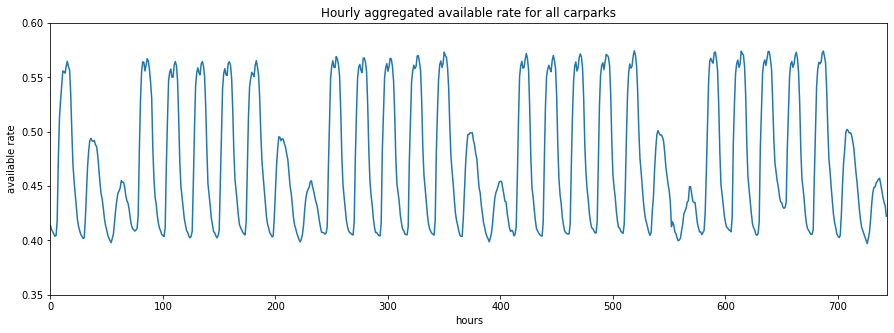

In [ ]:
import matplotlib.pyplot as plt


res['Average'] = res.apply(lambda x: x.sum(), axis=1) / 1943
res = res[['Average']]
average = res.iloc[:,0].values
index = [i for i in range(744)]
plt.figure(figsize=(15, 5))
plt.plot(index, average)
plt.title("Hourly aggregated available rate for all carparks")
plt.xlabel('hours')
plt.ylabel('available rate')
plt.xlim(0, 744, 100)
plt.ylim(0.35, 0.6, 0.05)
plt.show()

## Question 1.5  

> *Intuitively, we expect that carpark availability across certain carparks to be correlated. For example, many housing carparks would experience higher carpark availability during working hours. Using the same interval chosen in 1.4, write a function to find the top five carparks with which it shows the highest correlation. Demonstrate an example of this function call using a randomly selected carpark.*

**Here, we used the Pearsonr correlation coefficient to measure the linear relatioship between each carpark.**

In [ ]:
import pandas as pd
import scipy.stats as stats
import collections
import math

In [ ]:
Data = Data_all
sheet_names = list(Data.keys())[1:]

In [ ]:
def get_data(sheet_name):
    data = Data[sheet_name]
    data = data[data['Type']=='C']
    data = data[['Name','Available']]
    data = data.rename(columns={'Available': sheet_name})
    return data

In [ ]:
result = get_data(sheet_names[0])
for i in range(1,len(sheet_names)):
    data = get_data(sheet_names[i])
    result = result.merge(data, on='Name', how='inner')
result = result.T
res = result.set_axis(result.iloc[0],axis=1,inplace= False)
res = res.drop(index='Name')
res

Name,HE12,HLM,RHM,BM29,Q81,C20,FR3M,C32,C6,TG2,...,A61,Y38,BA4,JS1L,A26,B65M,B65L,BE3,BE3R,B8B
20211001T003000,64,486,125,87,76,122,160,86,106,67,...,513,137,487,5,110,498,0,37,106,225
20211001T013000,62,485,123,90,75,129,161,86,103,66,...,513,128,487,5,107,499,0,33,105,225
20211001T023000,58,484,120,89,76,143,159,83,105,67,...,518,123,486,6,106,498,0,31,103,224
20211001T033000,58,484,121,90,78,132,156,86,105,72,...,520,118,488,0,105,499,0,33,102,224
20211001T043000,46,485,119,90,78,128,153,85,104,71,...,594,115,489,0,108,498,0,29,101,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211031T193000,11,410,151,41,48,6,158,123,100,84,...,468,285,403,0,161,526,0,86,129,212
20211031T203000,30,457,148,60,54,48,162,113,95,83,...,463,281,395,2,154,522,0,67,128,213
20211031T213000,50,472,150,66,72,64,168,106,21,90,...,512,273,400,0,143,513,0,46,133,214
20211031T223000,62,499,141,71,67,99,161,98,32,89,...,534,252,424,0,144,507,0,61,126,218


In [ ]:
def Top5_Car_Park(name:str):
    dic = collections.defaultdict(str)
    colname = res.columns.values
    for i in range(0,len(colname)):
        r,p = stats.pearsonr(res[name],res.iloc[:,i])
        if not math.isnan(r):
            dic[colname[i]] = r
    a = sorted(dic.items(), key = lambda x:x[1],reverse = True)
    ans = []
    for i in range(1,6):
        ans.append(a[i][0])
    return ans

## Question 1.6
> *Group Project Proposal for Question 3: Please include a short proposal (around 500 words) of what your team intends to do for the Group Proposed Project in Question 3. For the group project proposal, you may use additional datasets to supplement your analysis or look at unaggregated data, etc. See Question 3 below for more information about this. Please use markdown in the iPython notebook to present your proposal.*






#### **Proposal for Group 8**
---

*   In this project, we will define and realize a machine learning module that can predict the number of available parking slots for several nearby carparks in future given specific geolocation information. The main goal is to utilize machine learning to successfully shape a model and give reliable future predicted outputs.   
*   The project aims to solve the problem in a real-life scenario. In real life, with the increasing amount of vehicle ownership rates, there is a high demand for smoothly parking a car in the city. Solving this problem is crucial for keeping traffic from jamming and increasing the road utilization rate. In this regard, developing a high-precision and efficient machine-learning model can alleviate this issue. The use case for this model is that when a driver plans to drive his car to someplace in the future, then he opens his map on his smartphone and key in the estimated departure time and the address, the map is smart enough that it directly returns the nearby carparks with the corresponding empty rate. With this information on hand, the driver does not need to drive from one carpark to another carpark to find an available parking space after arriving at the place. If this project is precise enough, not only does it save drivers the pain of searching for parking lots, but it also improves road utilization. This problem exactly needs to leverage machine learning, since the real-time database is not the “real” real-time the empty slots updates are not frequent enough and may experience technical issues. So, to resolve this technical difficulty, machine learning will come into play.

* Since we would like to predict the future empty rate for EVERY carpark, however, we cannot conclude that all carparks share the same attributes. For example, some carpark is near office building while some others are near to shopping mall. So their empty rates are distinct under the same period. Thus, we cannot use a single model to generalize every car park. However,  if we shape one model for each carpark, then the entire system will end up with a thousand machine-learning models that are running on our server, which is highly inefficient and costly. In this regard, we plan to resolve this issue by running clustering first, which can group those similar carparks into the same group. For every group, a dedicated machine-learning model will be defined and trained. For every carpark, it will have a unique tag to determine which group it belongs to. With this proposed solution, the number of models can be greatly reduced without harming the overall system performance. 

* The geolocation information will be retrieved from [Onemap](https://www.onemap.gov.sg/docs/), which is developed by the Singapore land authority. Once the geolocation is prompted by users, the most K nearby carpark as well as their empty rates will be returned by our program.
---


# Appendix 
> ## Helper function for pulling down data to local

In [ ]:
# Helper function for Question 1.2
# Pull data at a frequency of minutes in one day

def query(url):
    requestTime = 0
    while True:
        requestTime = requestTime + 1
        try:
            getUrl = requests.get(url)
            content = getUrl.text
            if "items" in content:
               break
            else:
                print(url, content)
                time.sleep(sleepTime)
        except Exception as e:
            print(url, str(e))
            time.sleep(sleepTime)

    pattern = re.compile(r'info"(?P<slots>.*?)],.*?"carpark_number":"(?P<name>.*?)",.*?"update_datetime":"(?P<update>.*?)"', re.S)
    result = pattern.finditer(content)     
    for iter in result:
        slots = iter.group("slots")
        patternSlot = re.compile(r'"total_lots":"(?P<total>.*?)".*?"lot_type":"(?P<type>.*?)".*?"lots_available":"(?P<available>.*?)"', re.S)
        resultSlot = patternSlot.finditer(slots)
        name1=iter.group("name")
        update1=iter.group("update")
        for iter2 in resultSlot:
            type1=iter2.group("type")
            entry=name1+"."+type1
            if(entry in data):
                lastUpd=data[entry][-1]
                if(update1!=lastUpd):
                    data[entry].append(update1)
            else:# not in
                data[entry]=[update1]

    return result    

def extract():
    year = 2022
    month = 10
    day = 15
    second = 00
    for hour in range(10, 20):
            for minute in range(0, 60, 1):
                url = 'https://api.data.gov.sg/v1/transport/carpark-availability'
                url = url + '?date_time=%d-%02d-%02dT%02d:%02d:%02d' % (year, month, day, hour, minute, second)
                print(url)
                qtime = '%d%02d%02dT%02d%02d%02d' % (year, month, day, hour, minute, second)
                result = query(url)
                if result is None:
                    print(qtime, 'Fail in main')
                else:
                    print(qtime, 'Success in main')
                    time.sleep(sleepTime)
                save_object(data)

extract()
save_object(data)

In [ ]:
# Helper function for question 1.4/1.5
# Pull data at a frequency of hours in one month


import requests
import re
from pandas import DataFrame, ExcelWriter
import time


def query(url):
    requestTime = 0
    while True:
        if requestTime >= 5:
            return None
        requestTime = requestTime + 1
        try:
            getUrl = requests.get(url)
            content = getUrl.text
            if "items" in content:
               break
            else:
                print(url, content)
                time.sleep(2)
        except Exception as e:
            print(url, str(e))
            time.sleep(2)

    data = []
    pattern = re.compile(r'info"(?P<slots>.*?)],.*?"carpark_number":"(?P<name>.*?)",.*?time":"(?P<updTime>.*?)"', re.S)
    result = pattern.finditer(content)        
    for iter in result:
        updTime = iter.group("updTime")
        if "2021-10" not in updTime and "2021-09" not in updTime:
            continue
        slots = iter.group("slots")
        patternSlot = re.compile(r'"total_lots":"(?P<total>.*?)".*?"lot_type":"(?P<type>.*?)".*?"lots_available":"(?P<available>.*?)"', re.S)
        resultSlot = patternSlot.finditer(slots)
        for iter2 in resultSlot:
            data.append({"Name": iter.group("name"), "Total": iter2.group("total"), "Available": iter2.group("available"), "Type": iter2.group("type")})

    return DataFrame(data)


def main():
    year = 2021
    month = 10
    minute = 30
    second = 00
    with ExcelWriter("Car_Park_Slots.xlsx", mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        for day in range(1, 32):
            for hour in range(24):
                url = 'https://api.data.gov.sg/v1/transport/carpark-availability'
                url = url + '?date_time=%d-%02d-%02dT%02d:%02d:%02d' % (year, month, day, hour, minute, second)
                qtime = '%d%02d%02dT%02d%02d%02d' % (year, month, day, hour, minute, second)
                result = query(url)
                if result is None:
                    print(qtime, 'Fail')
                else:
                    result.to_excel(writer, sheet_name=qtime)
                    print(qtime, 'Success')
                    time.sleep(2)


if __name__ == '__main__':
    main()